In [1]:
%load_ext autoreload
%autoreload 2
import random
from cap.dehaze import dehaze as cap_dehaze_img
from dcp.dehaze import dehaze as dcp_dehaze_img
from cap.dehaze import dehaze_video as cap_dehaze_vid
from dcp.dehaze import dehaze_video as dcp_dehaze_vid

from config import config
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error as compute_mse
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from tqdm import tqdm
import timeit
import numpy as np

In [2]:
_REVIDE_PATH = 'D:\\data\\dehaze\\REVIDE_inside\\Train'
_RESULT_PATH = '../result'
_VIDEO_PATH = 'D:\\data\\dehaze'

In [3]:
hazy_fold_path = os.path.join(_REVIDE_PATH, 'hazy', 'E001')
clear_fold_path = os.path.join(_REVIDE_PATH, 'gt', 'E001')

In [4]:
def get_clear(hazy_img_path):
    clear_img_path = hazy_img_path.replace('hazy', 'gt')
    return clear_img_path

In [5]:
def fbf_dehaze_with_global_atm(hazy, method, bov, g_atm):
    start = timeit.default_timer()
    if method == 'dcp':
        dehaze_frame, g_atm = dcp_dehaze_vid(hazy, config['dcp'], g_atm, bov)
    else:
        dehaze_frame, g_atm = cap_dehaze_vid(hazy, config['cap'], g_atm, bov)
    
    end = timeit.default_timer()
    time = end - start
    return dehaze_frame, g_atm, time

def fbf_dehaze_without_global_atm(hazy, method):
    start = timeit.default_timer()
    if method == 'dcp':
        dehaze_frame = dcp_dehaze_img(hazy, config['dcp'])
    else:
        dehaze_frame = cap_dehaze_img(hazy, config['cap'])
    
    end = timeit.default_timer()
    time = end - start
    return dehaze_frame, time

In [44]:
def process_real_video(in_name, out_name, method, vid_fps, vid_size, use_global = True):
    cap = cv2.VideoCapture(os.path.join(_VIDEO_PATH,in_name))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(out_name, fourcc, vid_fps, vid_size)
    list_time = []
    while(cap.isOpened()):
        ret, hazy_frame = cap.read()
        try:
            if (cv2.waitKey(1)) & (0xFF == ord('q')) & (hazy_frame is None):
                cap.release()
            else:
                if use_global:
                    if len(list_time)==0:
                        bov = True
                        g_atm = np.zeros((1,3))
                    else:
                        bov = False
                    dehaze_frame, g_atm, time = fbf_dehaze_with_global_atm(hazy_frame, method, bov, g_atm)
                else:
                    dehaze_frame, time = fbf_dehaze_without_global_atm(hazy_frame, method)
                list_time.append(time)
                out.write(dehaze_frame)
        except Exception as e:
            print(e)
            cap.release()
    out.release()
    return list_time

In [47]:
vid_in_name = 'E001_2\\hazy.avi'
# vid_size = (640, 480)
vid_size = (1280, 850)
vid_fps = 60
for g in [True, False]:
    for method in tqdm(['dcp', 'cap']):
        vid_out_name = vid_in_name.split('.')[0]
        out_fold = os.path.join(_VIDEO_PATH, vid_out_name)
        if not os.path.isdir(out_fold):
            os.mkdir(out_fold)
        vid_in = os.path.join(_VIDEO_PATH,vid_in_name)
        if g:
            vid_out = os.path.join(out_fold, f'{method}_gatm.avi')
        else:
            vid_out = os.path.join(out_fold, f'{method}.avi')
        time = process_real_video(vid_in, vid_out, method, vid_fps, vid_size, use_global = g)
        print(f'Processing time by {method}: {np.sum(time):.3f}')

 50%|████████████████████████████████                                | 1/2 [00:26<00:26, 26.02s/it]

'NoneType' object has no attribute 'copy'
Processing time by dcp: 24.207


100%|████████████████████████████████████████████████████████████████| 2/2 [01:16<00:00, 38.27s/it]


OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-c2l3r8zm\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Processing time by cap: 49.022


 50%|████████████████████████████████                                | 1/2 [00:25<00:25, 25.72s/it]

'NoneType' object has no attribute 'copy'
Processing time by dcp: 24.158


100%|████████████████████████████████████████████████████████████████| 2/2 [01:16<00:00, 38.39s/it]

OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-c2l3r8zm\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Processing time by cap: 49.571


### Investigate after creating video

In [ ]:
# video_name = 'traffic.mp4'
# vid_size = (600, 334)
# vid_fps = 30
# # cap = cv2.VideoCapture(os.path.join(_VIDEO_PATH,video_name))

# for omg in tqdm(list_omgs):
#     config['dcp']['omega'] = omg
#     method = 'dcp'
#     out_name = video_name.split('.')[0]
#     out = cv2.VideoCapture(os.path.join(os.path.join(_VIDEO_PATH, out_name), f'{method}_{omg:.2f}.avi'))

#     list_time = []
#     while(out.isOpened()):
#         _, dehazy_frame = out.read()
#         out.release()
#     color = (0, 0, 255)

# #     cv2.imwrite(f'../result/traffic/{out_name}_hazy_frame.png', hazy_frame)
# #     hazy_frame_maker = cv2.rectangle(hazy_frame.copy(), (340, 290), (500,320), color, 2)
# #     cv2.imwrite(f'../result/traffic/{out_name}_hazy_frame_marker.png', hazy_frame_maker)
# #     cv2.imwrite(f'../result/traffic/{out_name}_hazy_marker.png', hazy_frame[290:320,340:500])
    
#     cv2.imwrite(os.path.join(_VIDEO_PATH, out_name + '_analysis', f'dehazy_frame_{omg:.2f}.png'), dehazy_frame)
#     dehazy_frame_maker = cv2.rectangle(dehazy_frame.copy(), (340, 290), (500,320), color, 2)
#     cv2.imwrite(os.path.join(_VIDEO_PATH, out_name + '_analysis', f'dehazy_frame_marker_{omg:.2f}.png'), dehazy_frame_maker)
#     cv2.imwrite(os.path.join(_VIDEO_PATH, out_name + '_analysis', f'dehazy_marker_{omg:.2f}.png'), dehazy_frame[290:320,340:500])

### Visualize global atmospheric

In [23]:
vid_in_name = 'cross_10s.mp4'
vid_out_name = vid_in_name.split('.')[0]
out_fold = os.path.join(_VIDEO_PATH, vid_out_name)

method = 'cap'
org_cap = cv2.VideoCapture(os.path.join(_VIDEO_PATH,vid_in_name))
non_atm_cap = cv2.VideoCapture(os.path.join(out_fold, method+'.avi'))
atm_cap = cv2.VideoCapture(os.path.join(out_fold,method+'_gatm.avi'))
list_frame_org = []
list_frame_non_atm = []
list_frame_atm = []
while(atm_cap.isOpened()):
    if (cv2.waitKey(1)) & (0xFF == ord('q')):
        atm_cap.release()
    _, org_frame = org_cap.read()
    list_frame_org.append(org_frame)
    _, non_atm_frame = non_atm_cap.read()
    list_frame_non_atm.append(non_atm_frame)
    _, atm_frame = atm_cap.read()
    list_frame_atm.append(atm_frame)

KeyboardInterrupt: 

In [24]:
len(list_frame_org), len(list_frame_non_atm), len(list_frame_atm)

(1469, 1469, 1469)

In [35]:
def show_grid(list_imgs, titles):
    """
    utils function to display the images as a grid
    param:
        list_imgs: list of images
        titles: list of titles
    return:
    
    """
    fig=plt.figure(figsize=(20, 10), dpi=80)
    columns = len(list_imgs)
    rows = 1
    for i in range(0, columns*rows):
        img = list_imgs[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(titles[i])

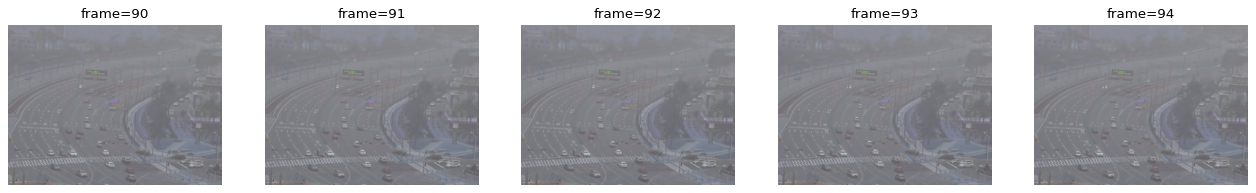

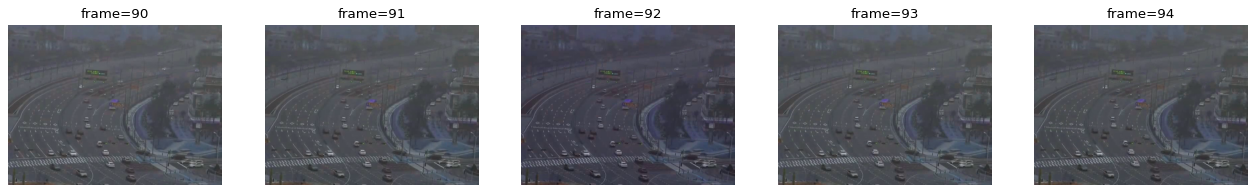

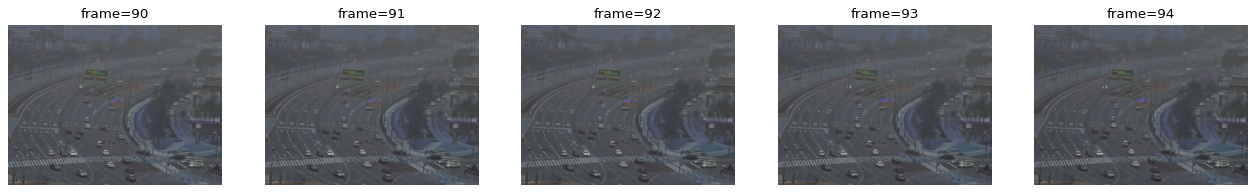

In [40]:
list_titles = [f'frame={item}' for item in list(range(90,95,1))]
show_grid(list_frame_org[90:95],list_titles)
plt.savefig(f'../result/comp_gatm_{vid_out_name}_org.png')
show_grid(list_frame_non_atm[90:95],list_titles)
plt.savefig(f'../result/comp_gatm_{vid_out_name}_non_atm.png')
show_grid(list_frame_atm[90:95],list_titles)
plt.savefig(f'../result/comp_gatm_{vid_out_name}_atm.png')